In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# 1. Loading the data

In [2]:
train_data, test_data = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train = train_data[0].reshape(-1,784).astype(float) / 255
y_train = train_data[1]

label is 8


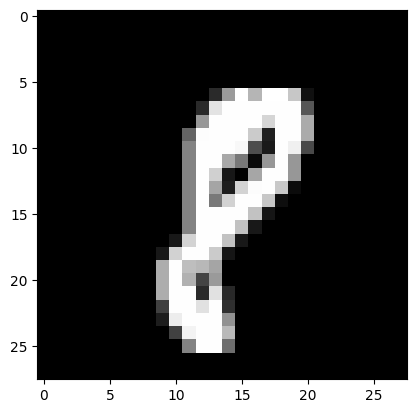

In [3]:
# exploring the data
i = np.random.randint(y_train.size)

print("label is", y_train[i])
plt.imshow(train_data[0][i], cmap='gray')

# 2. Building the model

We use Keras to build a fully-connected neural network.

For more details, see https://keras.io/guides/training_with_built_in_methods/

In [4]:
# source : https://keras.io/guides/training_with_built_in_methods/

def build_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(32, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
    return model

model = build_model()

loss = keras.losses.sparse_categorical_crossentropy

model.summary()


Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 784)]             0         
                                                                 
 dense_1 (Dense)             (None, 32)                25120     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 predictions (Dense)         (None, 10)                330       
                                                                 
Total params: 26506 (103.54 KB)
Trainable params: 26506 (103.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:
# untrained model
predicted_probas = model(x_train)
y_pred = np.argmax(predicted_probas, 1) # the prediction is the class with highest probability
y_pred[0:30]

array([0, 2, 8, 2, 8, 2, 8, 2, 6, 1, 9, 1, 2, 2, 8, 2, 2, 9, 1, 8, 2, 2,
       8, 8, 2, 1, 8, 9, 2, 2], dtype=int64)

In [6]:
# what we would like to get
y_train[0:30]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7], dtype=uint8)

# 3. Computing gradients

We are now going to implement the stochastic gradient method using the Keras functionalities. 

First, we need to understand how to compute gradients using auto-differentation (also called **backpropagation**).

In [7]:
# Source: https://keras.io/guides/writing_a_custom_training_loop_in_tensorflow/

# Example of gradient computation using automatic differentiation

# selecting a batch
x_train_batch = x_train[:8]
y_train_batch = y_train[:8]

# Open a GradientTape to record the operations run
# during the forward pass, which enables auto-differentiation.
with tf.GradientTape() as tape:
        # Run the forward pass of the layer.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.
    
        logits = model(x_train_batch)  # Logits for this minibatch (the logits are the name we give to the Neural Network output)

        # Compute the loss value for this minibatch.
        loss_value = loss(y_train_batch, logits)

# Use the gradient tape to automatically retrieve
# the gradients of the trainable variables with respect to the loss.
grad = tape.gradient(loss_value, model.trainable_weights)

We also define two important helper functions.

In [8]:
## update the weights by adding real_factor * update
def update_weights(model, update, real_factor = 1.):
    new_weights = model.trainable_weights.copy()

    # iterate over all layers
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] + real_factor * update[i]
        
    model.set_weights(new_weights)


# Evaluate model
def mean_loss(model, X, Y):
    logits = model(X)
    return np.mean(loss(Y, logits))

In [9]:
# evaluating the train loss on the whole dataset
# this is a costly operation, use sparsely
mean_loss(model, x_train, y_train)

2.3477697

# Question 4.1
How many optimization variables are we going to train using this model?

26500

# 4. Training the model

In [10]:
# Stochastic gradient algorithm
from tqdm import tqdm
# TO IMPLEMENT
def SGD(model, x_train, y_train, learning_rate, epochs=1, batch_size=1):
    np.random.seed(3)
    objective_values=[]
    with tqdm(total=int(epochs*np.shape(x_train)[0]/batch_size), desc="Training Progress") as pbar:
        for i in range (1,int(epochs*np.shape(x_train)[0]/batch_size)):
            n=np.random.randint(len(x_train))
            x_train_batch = x_train[n:n+1]
            y_train_batch = y_train[n:n+1]
            with tf.GradientTape() as tape:
                logits = model(x_train_batch)  
                loss_value = loss(y_train_batch, logits)
            grad = tape.gradient(loss_value, model.trainable_weights)
            update_weights(model,grad,-1/learning_rate(i))
            pbar.update(1)
            if i%1000==0 :
                objective_values.append(mean_loss(model, x_train, y_train))
            
    return(objective_values)


In [11]:
# initialize model
model = build_model()
Obj=SGD(model, x_train,y_train, np.sqrt)
print(len(Obj))

Training Progress: 100%|█████████▉| 59999/60000 [08:50<00:00, 113.05it/s]

59


59


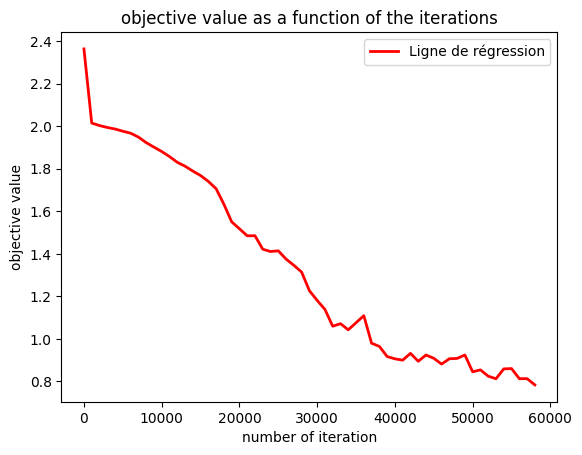

In [12]:
print(len(Obj))
plt.plot([i*1000 for i in range(len(Obj))], Obj, color='red', label='Ligne de régression', linewidth=2)

plt.title('objective value as a function of the iterations')
plt.ylabel('objective value')
plt.xlabel("number of iteration")
plt.legend()

plt.show()

Training Progress: 100%|█████████▉| 299999/300000 [48:07<00:00, 103.90it/s]


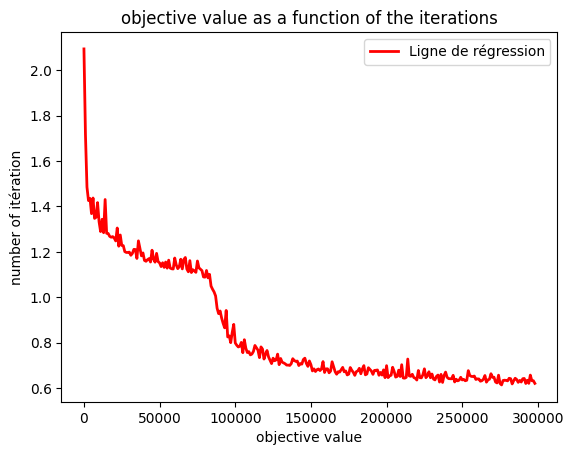

In [15]:
model2 = build_model()
Obj=SGD(model2, x_train,y_train, np.sqrt, 5)

plt.plot([i*1000 for i in range(len(Obj))], Obj, color='red', label='Ligne de régression', linewidth=2)

plt.title('objective value as a function of the iterations')
plt.xlabel('objective value')
plt.ylabel("number of itération")
plt.legend()

plt.show()

In [16]:
def SGDMiniBatch(model, x_train, y_train, learning_rate, epochs=1, batch_size=1):
    objective_values=[]
    with tqdm(total=int(epochs*np.shape(x_train)[0]/batch_size), desc="Training Progress") as pbar:
        for i in range (1,int(epochs*np.shape(x_train)[0]/batch_size)):
            n=np.random.randint(len(x_train))
            x_train_batch = x_train[n:n+1+batch_size]
            y_train_batch = y_train[n:n+1+batch_size]
            with tf.GradientTape() as tape:
                logits = model(x_train_batch)  
                loss_value = loss(y_train_batch, logits)
            grad = tape.gradient(loss_value, model.trainable_weights)
            update_weights(model,grad,-1/learning_rate(i)*(1/(batch_size)))
            pbar.update(1)
            if i%((epochs*np.shape(x_train)[0])/30)==0 :
                objective_values.append(mean_loss(model, x_train, y_train))
            
    return(objective_values)


Training Progress: 100%|█████████▉| 29999/30000 [03:50<00:00, 130.33it/s]


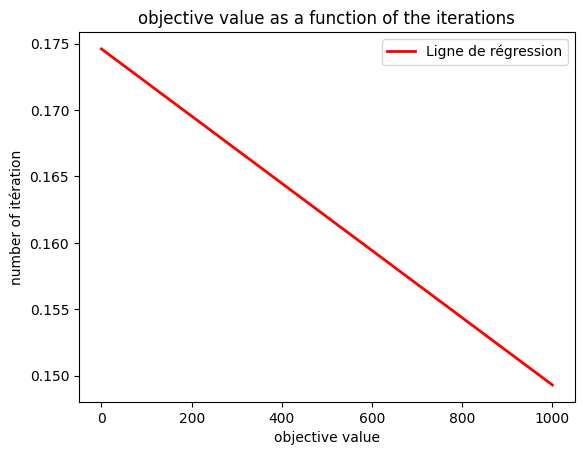

In [17]:
modelBatch = build_model()
ObjBatch=SGDMiniBatch(modelBatch, x_train,y_train, np.sqrt, 5,10)

plt.plot([i*1000 for i in range(len(ObjBatch))], ObjBatch, color='red', label='Ligne de régression', linewidth=2)

plt.title('objective value as a function of the iterations')
plt.xlabel('objective value')
plt.ylabel("number of itération")
plt.legend()

plt.show()

Question 6.2
According to you, what is the advantage of such a scheme?

Minibatching speeds up training and reduces noise by averaging gradients over small groups of data, while still allowing efficient use of memory and computational resources. This leads to faster convergence compared to processing one sample at a time.

Question 7.1
Evaluate the accuracy of the models on the training set and on the test set. Compare the
different methods.


In [13]:
def score(y_train,y_pred):
    score=0
    for i in range(len(y_train)):
        if y_pred[i]==y_train[i]:
            score+=1
    score=score/len(y_train)
    return(str(score))


predicted_probas = model(x_train)
y_pred = np.argmax(predicted_probas, 1)
print("Accuracy 1 epoch: " + score(y_train,y_pred))

predicted_probas = model2(x_train)
y_pred = np.argmax(predicted_probas, 1)
print("Accuracy 5 epochs: " + score(y_train,y_pred))

predicted_probas = modelBatch(x_train)
y_pred = np.argmax(predicted_probas, 1)
print("Accuracy Batch : " + score(y_train,y_pred))


Accuracy 1 epoch: 0.7443666666666666


NameError: name 'model2' is not defined

The best model is the SGD one